In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage import data, exposure
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn import neighbors
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn import metrics

from sklearn.utils.multiclass import unique_labels
from time import time
from matplotlib import offsetbox


## Loading data

In [2]:
# data-loading
images = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/images.npy')
labels = np.load('/mnt/e/Pattern Recognition/DigitRecognizer/data/labels.npy')

## Creating binary images by applying adaptive thresholding

In [3]:
#binary images
from skimage.filters import threshold_local
thresh_images = np.zeros(images.shape, dtype='uint')


for i in range(len(thresh_images)):
    
    threshed = np.zeros((28, 28), dtype='uint')
    im = images[i, :, :]
    
    
    threshed[im<80] = 1
    threshed[im>80] = 0
    
    thresh_images[i, :, :] = threshed
    
     

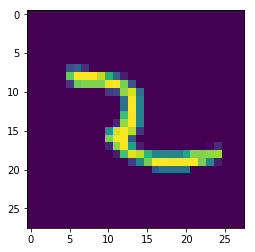

In [4]:
plt.imshow(images[558, :, :])

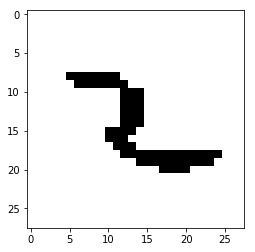

In [5]:
plt.imshow(thresh_images[558,:,:], cmap='gray')

## Creating HOG feature vector for dimentionality reduction

In [6]:
hog_results = np.zeros((392, 60000), dtype='float64')

for i in range(60000):
    hog_results[:, i] = hog(thresh_images[i, :, :], orientations=8, pixels_per_cell=(4, 4),
                            cells_per_block=(1, 1), visualize=False, multichannel=False, block_norm = 'L2-Hys')


## To visualize our high-dimentional HOG matrix, lets use t-distributed Stochastic Neighbor Embedding

In [ ]:
X = np.transpose(hog_results)
y = labels
n_samples, n_features = X.shape
n_neighbors = 30

In [ ]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(hog_results[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = TSNE(n_components=2, perplexity=50,early_exaggeration = 4.0, n_iter = 250, init='pca', random_state=0)

X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne)

plt.show()
np.save('./X_tsne.npy',X_tsne)

## PCA 

In [ ]:
#apply PCA to reduce dimentionality 
X = np.transpose(hog_results)
y = labels

pca = PCA(n_components = 16, svd_solver='full')
a = pca.fit_transform(X)


## Next step is to implement SGD classifier

In [7]:
#split dataset into training and test sets

X = np.transpose(hog_results)
y = labels
X_train, X_test, y_train, y_test = X[:50000], X[50000:], y[:50000], y[50000:]

In [8]:
#SGD classifier

sgd_clf = SGDClassifier(random_state=55, validation_fraction=0.2, verbose = 0, max_iter=100, n_jobs=30, shuffle=True)


In [9]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(X_test)[6544]

8

In [10]:
y_test[6544]

8

In [11]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.94822725, 0.95164097, 0.94683149])

In [12]:
#Random Forest Classifier to compare the results

randfor_clf = RandomForestClassifier(n_estimators=100, random_state=55, n_jobs=30)
cross_val_score(randfor_clf, X_train, y_train, cv=3, scoring='accuracy')


array([0.96268522, 0.96244075, 0.95991359])

In [13]:
#scaling for RF
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(randfor_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.96304517, 0.96202076, 0.95979357])

In [14]:
#SVC with RBF kernel  
svc_clf = SVC(kernel='rbf',gamma='auto',random_state=55)
cross_val_score(svc_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.9506869 , 0.95302094, 0.950012  ])

In [15]:
#ensemble of classifiers(Voting)

clf1 = sgd_clf
clf2 = randfor_clf
clf3 = svc_clf


eclf1 = VotingClassifier(estimators=[('sgd', clf1), ('rf', clf2), ('svc', clf3)], voting='hard')
cross_val_score(eclf1, X_train, y_train, cv=3, scoring='accuracy')

array([0.95620613, 0.95968081, 0.95553289])

In [16]:
eclf1 = eclf1.fit(X_train, y_train)

#### Testing 

In [21]:
expected = y_test
predicted = eclf1.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (eclf1, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier VotingClassifier(estimators=[('sgd', SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=30, penalty='l2',
      ...f',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None):
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       991
           1       0.97      0.98      0.98      1064
           2       0.96      0.98      0.97       990
           3       0.96      0.96      0.96      1030
           4       0.97      0.97      0.97       983
           5       0.97      0.95      0.96       915
           6       0.98      0.98      0.98       967
           7       0.97      0.9

#### plotting results

#### confusion matrices

In [29]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[ 979    5    2    0    0    1    2    1    1    0]
 [   0 1044   11    0    1    0    3    3    2    0]
 [   2    2  968    4    2    0    1    4    6    1]
 [   2    1    5  991    0   13    0    2   11    5]
 [   0    5    3    0  951    0    1    3    2   18]
 [   4    1    4   16    1  873   13    0    3    0]
 [   2    2    0    0    2    4  951    0    6    0]
 [   0    5    1    3    7    0    0 1039    4   31]
 [  10    5    9   10    4    9    3    7  946    6]
 [   6    3    2    9   14    1    0   12    3  911]]


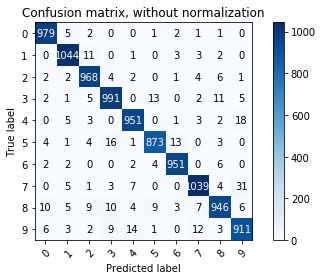

In [33]:
class_names = np.array([0,1,2,3,4,5,6,7,8,9])
plot_confusion_matrix(expected, predicted, classes=class_names,
                      title='Confusion matrix, without normalization')

#### Plotting predicted digits 

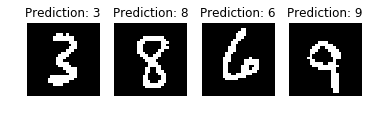

In [39]:
images_and_predictions = list(zip(thresh_images[50000:, :,:], predicted))
for index, (image, prediction) in enumerate(images_and_predictions[:4]):
    plt.subplot(2, 4, index + 5)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Prediction: %i' % prediction)

plt.show()